# 8장 머신러닝 응용
## 8.1 모델 개선

In [568]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve 
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

In [569]:
X = pd.read_pickle('../data/X.pkl') # 특성변수만 반영
y = pd.read_pickle('../data/y.pkl')
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [570]:
import os, glob
os.chdir('../output/')
model_dict = {}
for file in glob.glob('*.joblib'):
    model_dict[file.split('.')[0]] = load(file)
model_dict.keys()

dict_keys(['dt', 'gnb', 'Gradient Boosting', 'knn', 'lgr', 'Random Forest', 'smote_Decisiontree', 'smote_Extra Trees', 'smote_GNB', 'smote_Gradient Boosting', 'smote_KNN', 'smote_LGR', 'smote_Random Forest', 'smote_Ridge', 'smote_SVC', 'svc'])

In [571]:
y_test.value_counts(normalize=True)*100

0    65.25
1    34.75
Name: 구매, dtype: float64

In [572]:
from sklearn.linear_model import LogisticRegression
model = model_dict['lgr']
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       522
           1       0.58      0.27      0.37       278

    accuracy                           0.68       800
   macro avg       0.64      0.58      0.58       800
weighted avg       0.66      0.68      0.64       800



In [573]:
model = LogisticRegression(random_state=11, class_weight='balanced')
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.73      0.61      0.67       522
           1       0.44      0.58      0.50       278

    accuracy                           0.60       800
   macro avg       0.59      0.60      0.59       800
weighted avg       0.63      0.60      0.61       800



In [574]:
model = LogisticRegression(random_state=11, class_weight={0: 34.75, 1: 65.25})
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       522
           1       0.45      0.58      0.50       278

    accuracy                           0.60       800
   macro avg       0.59      0.60      0.59       800
weighted avg       0.63      0.60      0.61       800



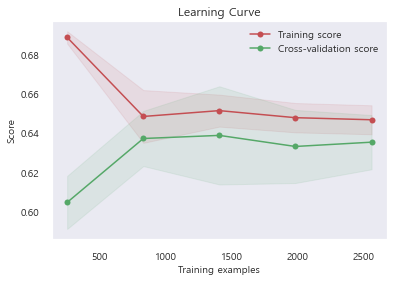

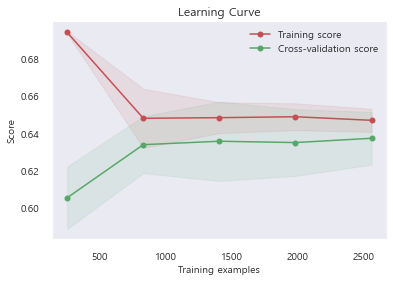

In [575]:
skplt.estimators.plot_learning_curve(model, X_train, y_train,
                                     scoring='accuracy')
skplt.estimators.plot_learning_curve(model, X_train, y_train,
                                     scoring='recall_macro')

(array([ 28.,  51.,  99.,  92., 174., 148.,  89.,  61.,  37.,  21.]),
 array([0.09532134, 0.17700278, 0.25868421, 0.34036565, 0.42204708,
        0.50372852, 0.58540995, 0.66709138, 0.74877282, 0.83045425,
        0.91213569]),
 <a list of 10 Patch objects>)

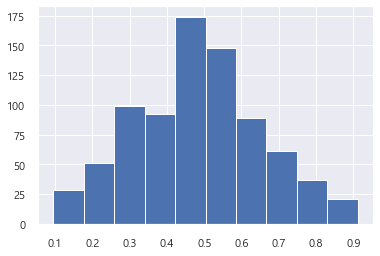

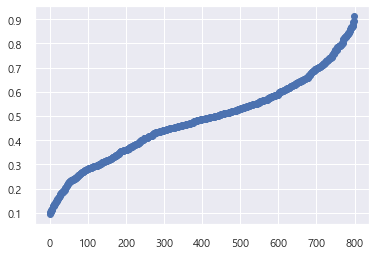

In [576]:
y_proba = model.predict_proba(X_test)
plt.hist(y_proba[:,1]); plt.show()
plt.scatter(np.arange(len(y_test)), np.sort(y_proba[:,1]))

In [577]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier) 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier)
import lightgbm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score, log_loss
from sklearn.metrics import brier_score_loss, matthews_corrcoef
from scipy.stats import ks_2samp

In [578]:
classifiers = {}
classifiers.update({'KNN': KNeighborsClassifier()})

classifiers.update({'GNB': GaussianNB()})

classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})

classifiers.update({'SVC': SVC(class_weight='balanced', probability=True)})

classifiers.update({'Decisiontree': DecisionTreeClassifier(class_weight='balanced')})

classifiers.update({'Extratree': ExtraTreesClassifier(class_weight='balanced', 
                                                      n_estimators=250)})

classifiers.update({'Bagging': BaggingClassifier(DecisionTreeClassifier(),
                                                 n_estimators=100)})

classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced',
                                                            n_estimators=100)})

classifiers.update({'AdaBoost': AdaBoostClassifier(n_estimators=100)})

classifiers.update({'Gradient Boosting': GradientBoostingClassifier(n_estimators=100,
                                                                 max_depth=2)})

In [579]:
from tqdm import tqdm_notebook
kf = KFold(n_splits=3)
results = {}
for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2,
                          scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'Test recall_macro': recall_score(y_test, y_pred, average='macro'),
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
              'KS_pvalue': ks_2samp(y_test, y_pred)[1]
             }
 
    results.update({classifier_label: result})

In [580]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,Training recall_macro,Test recall_macro,AUROC,Average PR,F1-score,Accuracy,Log_loss,Brier_score,KS_pvalue
Random Forest,0.613762,0.588584,0.666305,0.525358,0.397229,0.609465,0.613543,0.21038,1.14948e-08
SVC,0.622886,0.599541,0.651896,0.509184,0.500803,0.622644,0.614289,0.212076,0.00729065
Gradient Boosting,0.59388,0.579316,0.64067,0.51917,0.345361,0.590981,0.615224,0.212149,7.48617e-16
Bagging,0.610707,0.60012,0.660954,0.520882,0.436831,0.608599,0.631155,0.215071,9.88009e-05
Extratree,0.613389,0.621703,0.665688,0.51348,0.475992,0.59963,0.654016,0.217569,0.0012006
LGR,0.622337,0.59704,0.64291,0.499125,0.503125,0.621203,0.662871,0.234837,0.000292341
AdaBoost,0.588863,0.570833,0.63668,0.5081,0.354916,0.584019,0.691117,0.248985,5.82783e-11
GNB,0.505284,0.577138,0.623684,0.489587,0.477848,0.562599,1.12958,0.29548,0.00145431
KNN,0.575492,0.559284,0.607311,0.417749,0.39521,0.571352,2.32192,0.2478,0.0455597
Decisiontree,0.564307,0.568201,0.568201,0.386378,0.436036,0.570356,13.5133,0.39125,1


In [581]:
classifier_labels = []
probas_list = []
for classifier_label, classifier in classifiers.items():
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}   
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2, scoring = 'f1_micro')  
    y_proba = gs.fit(X_train, y_train).predict_proba(X_test)
    probas_list.append(y_proba)
    classifier_labels.append(classifier_label)

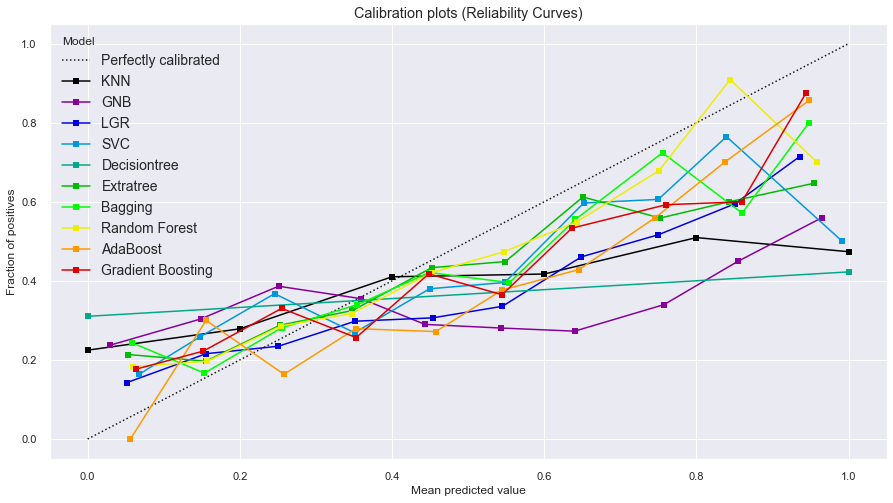

In [582]:
sns.set()
skplt.metrics.plot_calibration_curve(y_test, probas_list, classifier_labels, figsize=(15,8))
leg = plt.legend(title='Model', fontsize = 14)
leg._legend_box.align = 'left'

DiscriminationThreshold(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDE3B7E808>,
                        force_model=None, model=None)

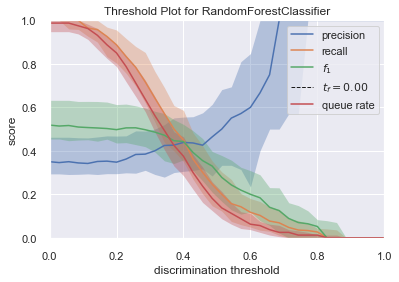

In [583]:
from yellowbrick.classifier import DiscriminationThreshold
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
visualizer = DiscriminationThreshold(rf)
visualizer.fit(X_test, y_test)  # Fit the training data to the visualizer
visualizer.poof()

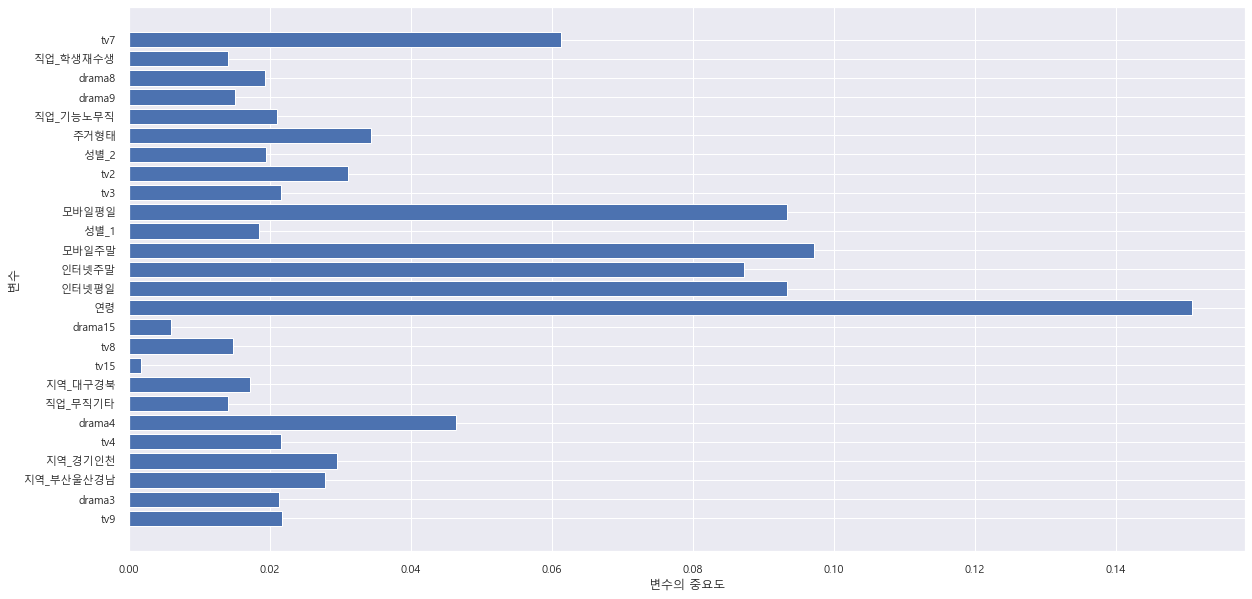

In [584]:
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
def plot_feature_importances(model):
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.barh(range(X_train.shape[1]), rf.feature_importances_, align='center')
    plt.yticks(np.arange(X_train.shape[1]), X_train.columns)
    plt.xlabel('변수의 중요도')
    plt.ylabel('변수')
    plt.savefig('../output/Feature_importance') # 그림 파일 저장
plot_feature_importances(model)

In [585]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=0)
result.importances_mean.round(3)
np.argsort(-result.importances_mean)
X_train.columns

array([-0.002, -0.001,  0.026,  0.003,  0.007,  0.002,  0.002,  0.002,
        0.   , -0.   ,  0.001,  0.002,  0.009,  0.002,  0.004,  0.   ,
        0.004,  0.003,  0.004, -0.   , -0.002,  0.001,  0.002,  0.001,
       -0.002,  0.007])

array([ 2, 12,  4, 25, 14, 16, 18, 17,  3,  6, 11, 22,  7, 13,  5, 10, 23,
       21,  8, 15, 19,  9,  1, 20,  0, 24], dtype=int64)

Index(['tv9', 'drama3', '지역_부산울산경남', '지역_경기인천', 'tv4', 'drama4', '직업_무직기타',
       '지역_대구경북', 'tv15', 'tv8', 'drama15', '연령', '인터넷평일', '인터넷주말', '모바일주말',
       '성별_1', '모바일평일', 'tv3', 'tv2', '성별_2', '주거형태', '직업_기능노무직', 'drama9',
       'drama8', '직업_학생재수생', 'tv7'],
      dtype='object')

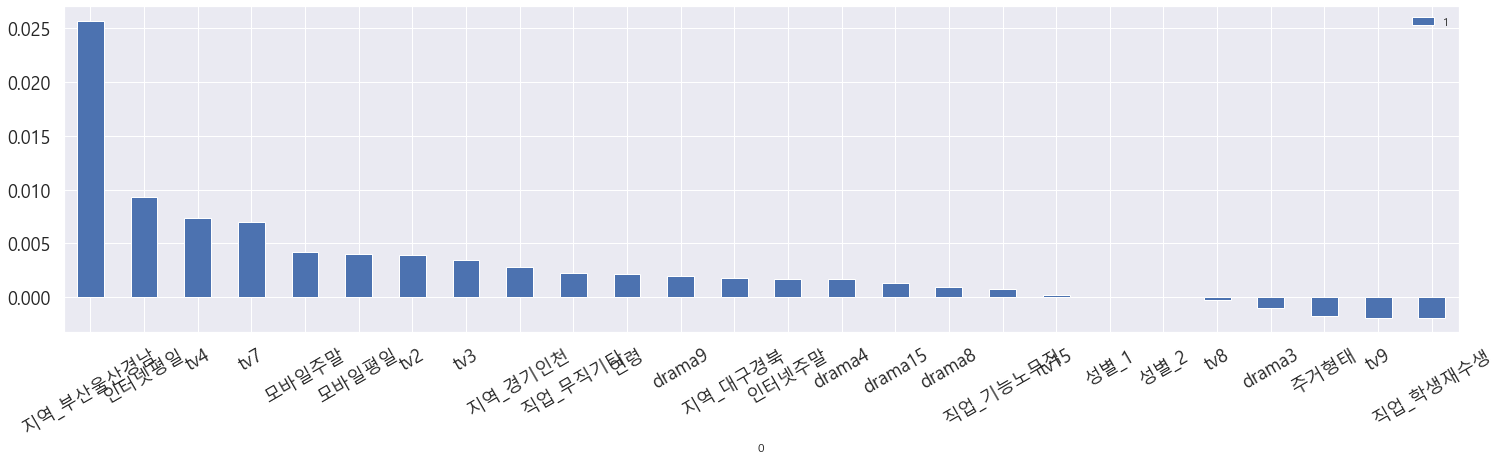

In [586]:
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
data = pd.DataFrame(list(zip(X_train.columns, result.importances_mean)))
data.sort_values(by =1, ascending= False, inplace =True)
data.plot(kind='bar', x=0, y=1, rot='30', figsize=(25, 6), fontsize=18)

In [587]:
result.importances_mean.argsort()
X_train.columns

array([24,  0, 20,  1,  9, 19, 15,  8, 21, 23, 10,  5, 13,  7, 22, 11,  6,
        3, 17, 18, 16, 14, 25,  4, 12,  2], dtype=int64)

Index(['tv9', 'drama3', '지역_부산울산경남', '지역_경기인천', 'tv4', 'drama4', '직업_무직기타',
       '지역_대구경북', 'tv15', 'tv8', 'drama15', '연령', '인터넷평일', '인터넷주말', '모바일주말',
       '성별_1', '모바일평일', 'tv3', 'tv2', '성별_2', '주거형태', '직업_기능노무직', 'drama9',
       'drama8', '직업_학생재수생', 'tv7'],
      dtype='object')

{'whiskers': [<matplotlib.lines.Line2D at 0x1eded8a4cc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1eded8bcf08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eded8bc748>,
 'medians': [<matplotlib.lines.Line2D at 0x1eded8bfc88>,
 'fliers': [<matplotlib.lines.Line2D at 0x1eded8bfd08>,
 'means': []}

Text(0.5, 1.0, 'Permutation Importance of each feature')

Text(0, 0.5, 'Features')

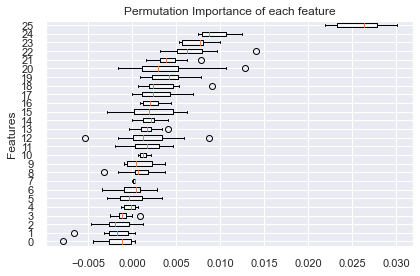

In [588]:
sns.set()
fig, ax = plt.subplots()
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=range(X.shape[1]))
ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()

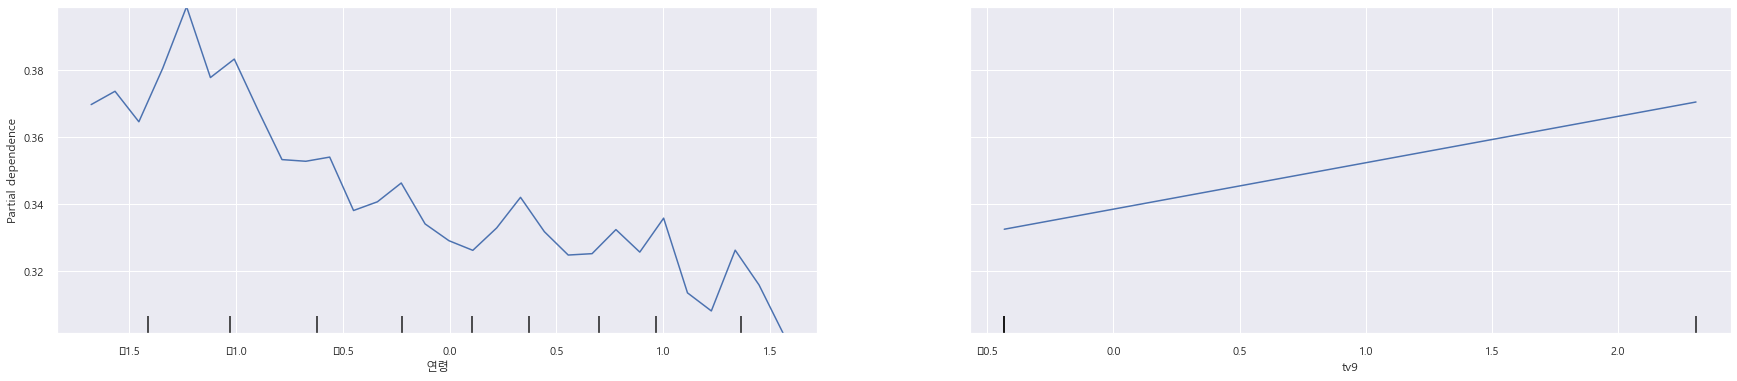

In [589]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['figure.figsize'] = (30,6)
features = ['연령', 'tv9']
plot_partial_dependence(rf, X_train, features, n_jobs=3, grid_resolution=30)
fig = plt.gcf(); fig.subplots_adjust(hspace=2)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edec2868c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf24082c8>})

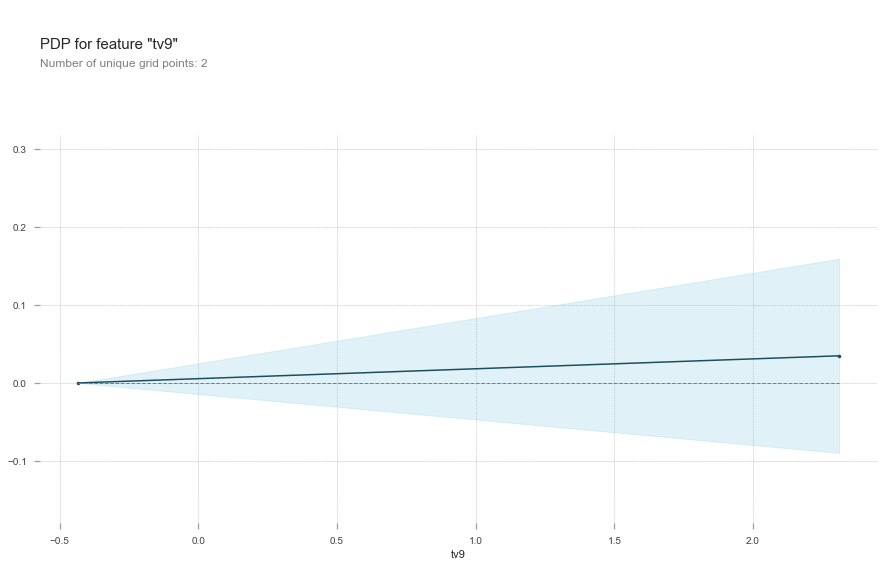

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf23bd5c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf2991588>})

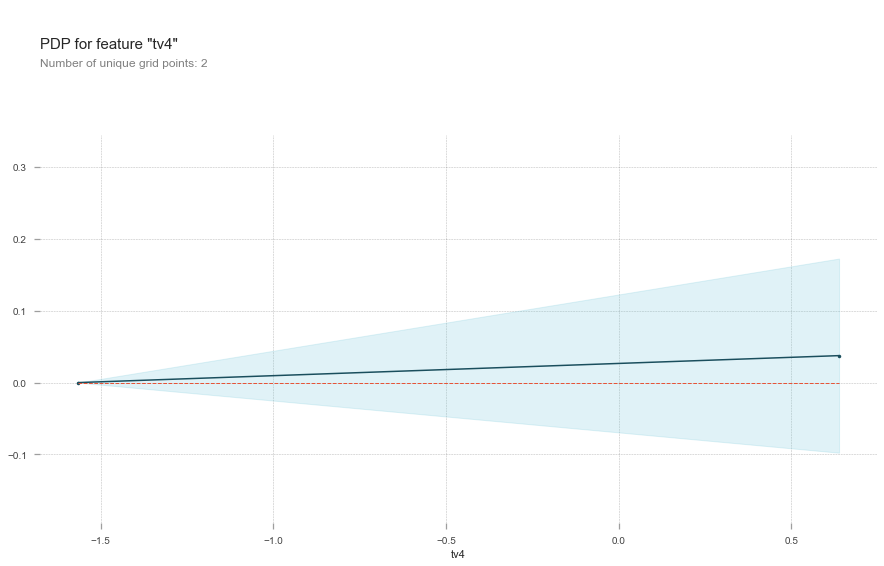

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf26cb0c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf2915a88>})

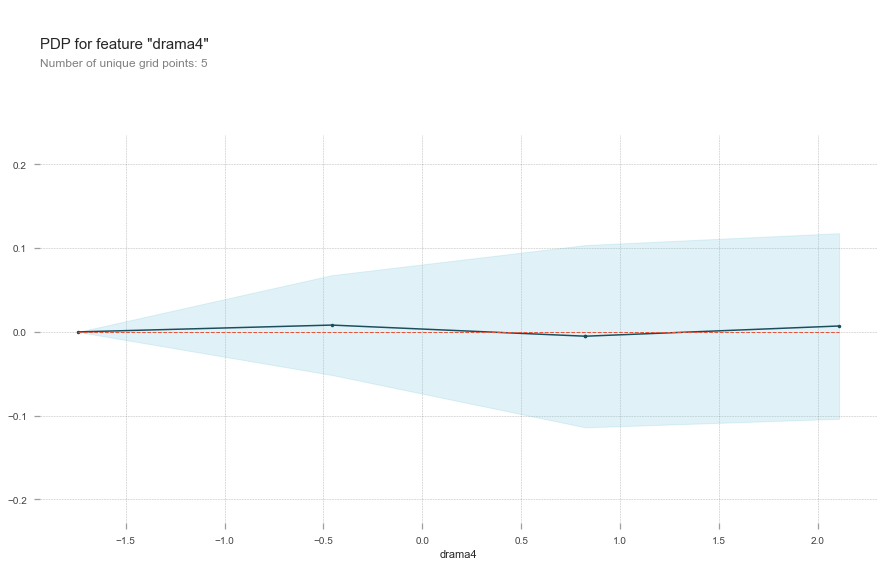

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf269ef88>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1edf2a2a248>})

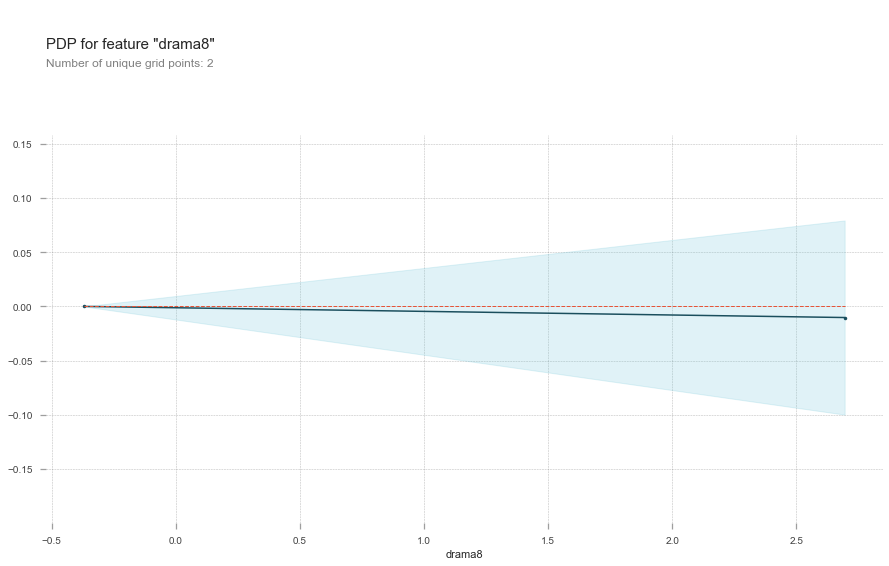

In [590]:
from pdpbox import pdp, get_dataset, info_plots # pip install pdpbox
for i in ['tv9', 'tv4', 'drama4', 'drama8'] :
    pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, 
                               model_features=X_test.columns, feature=i)
    pdp.pdp_plot(pdp_goals, i)
    plt.show()

## 8.2 SMOTE

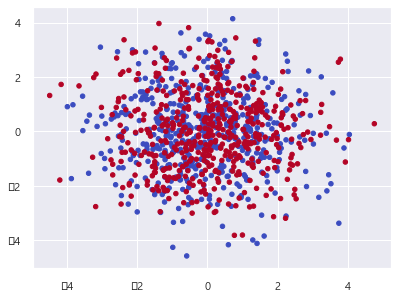

In [591]:
plt.rcParams['figure.figsize'] = (6.4, 4.8)
from sklearn.datasets import make_blobs
n_samples_1 = 500; n_samples_2 = 500 
centers = [[0.0, 0.0], [0.0, 0.0]]; clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2], centers=centers,
                  cluster_std=clusters_std, random_state=0, shuffle=False)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

In [592]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 1024)
y_predict = model.fit(X_train, y_train).predict(X_test)
y_scores = model.fit(X_train, y_train).decision_function(X_test)

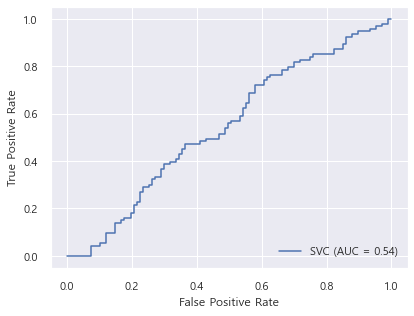

              precision    recall  f1-score   support

           0       0.63      0.30      0.41       107
           1       0.50      0.80      0.61        93

    accuracy                           0.53       200
   macro avg       0.56      0.55      0.51       200
weighted avg       0.57      0.53      0.50       200



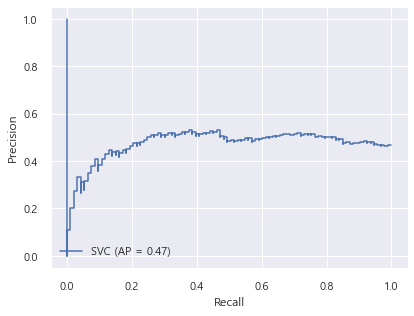

In [593]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
svc_disp = plot_roc_curve(model, X_test, y_test); plt.show()
svc_disp = plot_precision_recall_curve(model, X_test, y_test)
print(classification_report(y_test, y_predict))

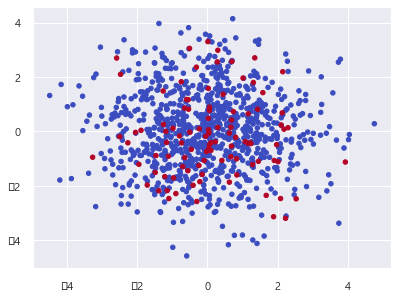

In [594]:
plt.rcParams['figure.figsize'] = (6.4, 4.8)
from sklearn.datasets import make_blobs
n_samples_1 = 900; n_samples_2 = 100 
centers = [[0.0, 0.0], [0.0, 0.0]]; clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2], centers=centers,
                  cluster_std=clusters_std, random_state=0, shuffle=False)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

In [595]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 1024)
y_predict = model.fit(X_train, y_train).predict(X_test)
y_scores = model.fit(X_train, y_train).decision_function(X_test)

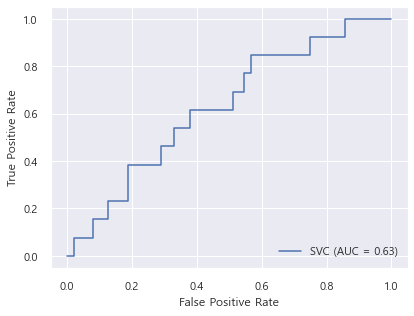

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       187
           1       0.00      0.00      0.00        13

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.94      0.90       200



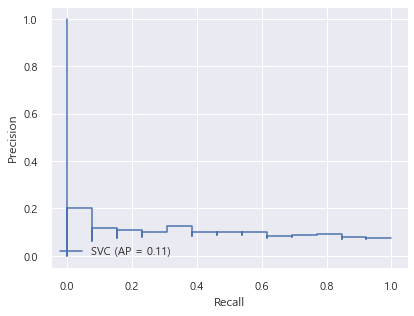

In [596]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
svc_disp = plot_roc_curve(model, X_test, y_test); plt.show()
svc_disp = plot_precision_recall_curve(model, X_test, y_test)
print(classification_report(y_test, y_predict))

In [597]:
cross = np.array([[9801, 99], [0, 100]])
data = pd.DataFrame(cross, index=['Uninfected', 'Infected'], 
                    columns=['Test negative', 'Test positive'])
data['Total']= data.sum(axis=1)
data.loc['Total'] = data.sum()
data

,Test negative,Test positive,Total
Uninfected,9801,99,9900
Infected,0,100,100
Total,9801,199,10000


In [598]:
tn = data.iloc[0,0]; fp=data.iloc[0,1]
fn = data.iloc[1,0]; tp=data.iloc[1,1]
fpr = fp/data.iloc[0,2]; tpr = tp/data.iloc[1,2]
print(f'알러지가 없는데 있다고 진단할 확률(허위양성율, fpr)은 {fpr*100} %')
print(f'알러지가 있는데 없다고 진단할 확률(참음성율, tpr)은 {tpr*100} %')

알러지가 없는데 있다고 진단할 확률(허위양성율, fpr)은 1.0 %
알러지가 있는데 없다고 진단할 확률(참음성율, tpr)은 100.0 %


In [599]:
print(f'알러지 진단을 받았는데 실제 알러지일 확률(양성 정밀도)은 {tp/(fp+tp)*100} %')

알러지 진단을 받았는데 실제 알러지일 확률(양성 정밀도)은 50.25125628140703 %


In [600]:
df = pd.read_pickle('../data/4장자료_02.pkl')
df['구매'].value_counts(normalize=True)

0    0.897173
1    0.102827
Name: 구매, dtype: float64

In [601]:
from sklearn.preprocessing import OrdinalEncoder
df['주거형태'].replace({'영구임대': '월세', '사택기타':'월세'}, inplace=True) 
enc = OrdinalEncoder()
enc.fit(df['주거형태'].values.reshape(-1,1))
df['주거형태'] = enc.transform(df['주거형태'].values.reshape(-1,1))

df['학력'] = df['학력'].map({'정규교육없음':0,'초등학교졸업':0,
                         '중학교졸업':0,'중학교재학':0, 
                         '고등학교졸업':1,'고등학교재학':1, 
                         '전문대학졸업':2,'전문대학재학':2,
                         '대학교졸업':2,'대학교재학':2, 
                         '대학원졸업':3,'대학원재학':3}) 

from sklearn.preprocessing import StandardScaler
Cats = df.columns[df.dtypes == 'category']
float_list = [item for item in df.drop(['구매'], axis=1).columns if item not in Cats]
scaler = StandardScaler()
for col in float_list : 
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

OrdinalEncoder()

In [602]:
X = pd.get_dummies(df.drop(['구매'], axis=1), prefix= Cats)
y = df['구매']

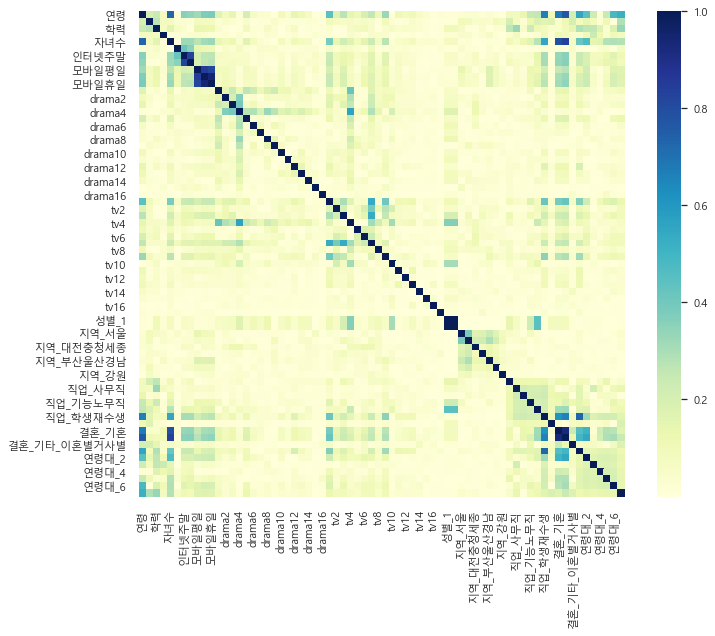

In [603]:
corr_matrix = X.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
plt.rcParams['font.family']='Malgun Gothic'
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig('../output/correlation_matrix.png', dpi = 1080)

In [604]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                  k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop
X = X.drop(to_drop, axis = 1)

['인터넷휴일', '모바일주말', '모바일휴일', '성별_2', '결혼_미혼']

In [605]:
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 11)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
Counter(y_train)

((3197, 65), (800, 65), (3197,), (800,))

Counter({0: 2869, 1: 328})

In [606]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [607]:
kf = KFold(n_splits=5)
lgr = LogisticRegression(class_weight='balanced', random_state=11)
params = [{'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}] 
grid = GridSearchCV(lgr, param_grid=params, cv=kf, scoring = 'recall_macro')

In [608]:
y_predict = grid.fit(X_train, y_train).predict(X_test)
confusion_matrix(y_test, y_predict)
print(classification_report(y_test, y_predict))

array([[477, 240],
       [ 39,  44]], dtype=int64)

              precision    recall  f1-score   support

           0       0.92      0.67      0.77       717
           1       0.15      0.53      0.24        83

    accuracy                           0.65       800
   macro avg       0.54      0.60      0.51       800
weighted avg       0.84      0.65      0.72       800



In [609]:
from imblearn.over_sampling import SMOTE # pip install imbalearn
sm = SMOTE(sampling_strategy = 0.5, random_state=10)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_train.shape, X_train_smote.shape
Counter(y_train), Counter(y_train_smote)
(Counter(y_train_smote)[1] /(Counter(y_train_smote)[0] + 
                             Counter(y_train_smote)[1])*100)

((3197, 65), (4303, 65))

(Counter({0: 2869, 1: 328}), Counter({0: 2869, 1: 1434}))

33.32558679990704

In [610]:
sm = SMOTE(random_state=10)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_train.shape, X_train_smote.shape
Counter(y_train), Counter(y_train_smote)
X_train, y_train = X_train_smote, y_train_smote

((3197, 65), (5738, 65))

(Counter({0: 2869, 1: 328}), Counter({0: 2869, 1: 2869}))

In [611]:
X_train, y_train = X_train_smote, y_train_smote
X_train.shape, y_train.shape

((5738, 65), (5738,))

In [612]:
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import (DecisionTreeClassifier, ExtraTreeClassifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [613]:
classifiers = {}
classifiers.update({'LGR': LogisticRegression(random_state=11, solver ='liblinear')})
classifiers.update({'SVC': SVC(random_state=11, max_iter=300, probability=True)})
classifiers.update({'Decisiontree': DecisionTreeClassifier()})
classifiers.update({'Random Forest': RandomForestClassifier()})
classifiers.update({'Gradient Boosting': GradientBoostingClassifier()})

In [614]:
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import ExtraTreeClassifier

classifiers.update({'Ridge': RidgeClassifier()})
classifiers.update({'Extra Trees': ExtraTreeClassifier()})

classifiers

{'LGR': LogisticRegression(random_state=11, solver='liblinear'),
 'SVC': SVC(max_iter=300, probability=True, random_state=11),
 'Decisiontree': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier(),
 'Gradient Boosting': GradientBoostingClassifier(),
 'Ridge': RidgeClassifier(),
 'Extra Trees': ExtraTreeClassifier()}

In [615]:
DECISION_FUNCTIONS = {'SVC', 'Ridge'}

In [616]:
parameters = {}
parameters.update({'LGR': 
{ 
'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}
})

In [617]:
parameters.update({'SVC': 
{ 
'classifier__kernel': ['linear', 'rbf', 'poly'],
'classifier__gamma': ['auto'],
'classifier__C': [0.1, 0.5, 1, 5, 10, 50, 100],
'classifier__degree': [1, 2, 3, 4, 5, 6]
}})

In [618]:
parameters.update({'Decisiontree': 
{ 
'classifier__criterion' :['gini', 'entropy'],
'classifier__splitter': ['best', 'random'],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [1,2,3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
}})

In [619]:
parameters.update({'Random Forest': 
{ 
'classifier__n_estimators': [200],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__criterion' :['gini', 'entropy']     ,
'classifier__n_jobs': [-1]
}})

In [620]:
parameters.update({'Gradient Boosting': 
{ 
'classifier__learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
'classifier__n_estimators': [200],
'classifier__max_depth': [2,3,4,5,6],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__subsample': [0.8, 0.9, 1]
}})

In [621]:
parameters.update({'Ridge': 
{ 
'classifier__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
}})

In [622]:
parameters.update({'Extra Trees': 
{ 
'classifier__criterion' :['gini', 'entropy'],
'classifier__splitter': ['best', 'random'],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [1,2,3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
}})

In [623]:
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss

In [624]:
results = {}
for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('scaler', StandardScaler()), ('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = parameters[classifier_label]
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = 2,  n_iter = 2,
                            scoring = 'recall_macro')    


    y_pred = gs.fit(X_train, y_train).predict(X_test)
    
    if classifier_label in DECISION_FUNCTIONS:
        y_proba = gs.decision_function(X_test)
        ap = average_precision_score(y_test, y_proba)
    else:
        y_proba = gs.predict_proba(X_test)[:,1]
        ap = average_precision_score(y_test, y_proba)

   
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'AUROC': roc_auc_score(y_test, y_proba),
              'Average PR': ap,
              'F1-score': f1_score(y_test, y_pred),
              'CV accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
             }
    
    results.update({classifier_label: result})
    dump(gs.fit(X_train, y_train), '../output/smote_%s.joblib'%classifier_label)

['../output/smote_LGR.joblib']

['../output/smote_SVC.joblib']

['../output/smote_Decisiontree.joblib']

['../output/smote_Random Forest.joblib']

['../output/smote_Gradient Boosting.joblib']

['../output/smote_Ridge.joblib']

['../output/smote_Extra Trees.joblib']

In [625]:
pd.DataFrame(results).T.sort_values(by = 'F1-score', ascending=False)

,Best Parameters,Training recall_macro,AUROC,Average PR,F1-score,CV accuracy,Log_loss
Decisiontree,"{'classifier__splitter': 'best', 'classifier__...",0.656002,0.662499,0.151048,0.250627,0.717514,0.649368
Random Forest,"{'classifier__n_jobs': -1, 'classifier__n_esti...",0.882517,0.664785,0.184217,0.206186,0.855882,0.479852
Extra Trees,"{'classifier__splitter': 'random', 'classifier...",0.683141,0.543941,0.124215,0.204545,0.686664,0.647863
SVC,"{'classifier__kernel': 'poly', 'classifier__ga...",0.853228,0.52518,0.144121,0.171123,0.820357,2.63868
Gradient Boosting,"{'classifier__subsample': 1, 'classifier__n_es...",0.926431,0.637932,0.16807,0.0917431,0.904701,0.346849
LGR,"{'classifier__penalty': 'l2', 'classifier__C':...",0.914931,0.650283,0.155536,0.0208333,0.918978,0.340712
Ridge,{'classifier__alpha': 1e-05},0.905692,0.640907,0.157808,0,0.910441,3.58401


In [626]:
import glob
glob.glob('../output/sm*.joblib')

['../output\\smote_Decisiontree.joblib',
 '../output\\smote_Extra Trees.joblib',
 '../output\\smote_GNB.joblib',
 '../output\\smote_Gradient Boosting.joblib',
 '../output\\smote_KNN.joblib',
 '../output\\smote_LGR.joblib',
 '../output\\smote_Random Forest.joblib',
 '../output\\smote_Ridge.joblib',
 '../output\\smote_SVC.joblib']

In [627]:
lgr = load('../output/smote_LGR.joblib')
y_predict = lgr.predict(X_test)
confusion_matrix(y_test, y_predict)
print(classification_report(y_test, y_predict))

array([[705,  12],
       [ 82,   1]], dtype=int64)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       717
           1       0.08      0.01      0.02        83

    accuracy                           0.88       800
   macro avg       0.49      0.50      0.48       800
weighted avg       0.81      0.88      0.84       800



In [628]:
from imblearn.pipeline import Pipeline, make_pipeline
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(random_state=13, 
                                                     class_weight='balanced'))
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.71584964, 0.69584977, 0.90627161, 0.4978204 , 0.4978204 ])

In [629]:
imba_pipeline
param = {
'randomforestclassifier__n_estimators': [int(x) for x in np.linspace(10, 100, 10)],
'randomforestclassifier__max_depth': [int(x) for x in np.linspace(5, 20, 10)],
'randomforestclassifier__min_samples_split': [2, 5, 10],
'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=13))])

In [632]:
rs = RandomizedSearchCV(imba_pipeline, param, cv=kf,  n_iter=50, 
                        scoring='recall_macro')
y_predict = rs.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       717
           1       0.26      0.17      0.21        83

    accuracy                           0.86       800
   macro avg       0.59      0.56      0.57       800
weighted avg       0.84      0.86      0.85       800

